In [48]:
import matplotlib.pyplot as plt
import random
from copy import deepcopy

COLORS = [
    'red', 'green', 'blue', 'yellow', 'magenta', 'cyan',
    'orange', 'purple', 'lime', 'teal', 'brown', 'pink'
]

def plot_result(pil_img, predicted_data, ground_truth_data, model, title):
    """
    Plots predicted boxes and ground truth boxes side by side for comparison.
    
    Args:
        pil_img (PIL.Image): The original image
        predicted_data (dict): Dictionary containing prediction data with keys:
            - 'scores': tensor of confidence scores
            - 'labels': tensor of label indices
            - 'boxes': tensor of bounding boxes in format [xmin, ymin, xmax, ymax]
        ground_truth_data (dict): Dictionary containing ground truth data with keys:
            - 'annotations': list of dicts with 'bbox' [xmin, ymin, w, h] and 'category_id'
            - 'cat_id_to_label': dict mapping category IDs to label strings
        title (str): Title for the plot
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    fig.suptitle(title, fontsize=16)
    
    # Left plot - Predictions
    ax1.imshow(pil_img)
    ax1.set_title("Predicted")
    ax1.axis('off')
    

    # Add predictions to left plot
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(
            predicted_data['scores'].tolist(), 
            predicted_data['labels'].tolist(), 
            predicted_data['boxes'].tolist(), 
            colors):
        
        ax1.add_patch(plt.Rectangle(
            (xmin, ymin), 
            xmax - xmin, 
            ymax - ymin,
            fill=False, 
            color=c, 
            linewidth=2
        ))
        
 
        text = f'{model.config.id2label[label]}: {score:.2f}'
        
        ax1.text(
            xmin, 
            ymin, 
            text, 
            fontsize=9,
            bbox=dict(facecolor='white', alpha=0.7),
            color=c
        )
    
    # Right plot - Ground Truth
    ax2.imshow(pil_img)
    ax2.set_title("Ground Truth")
    ax2.axis('off')
    
    # ensure enough colours
    annotations = ground_truth_data['annotations']
    colours = deepcopy(COLORS) * ((len(annotations) // len(COLORS)) + 1)
    random.shuffle(colours)
    
    cat_id_to_label = ground_truth_data['cat_id_to_label']
    
    for ann, colour in zip(annotations, colours):
        xmin, ymin, w, h = ann['bbox']
        label = cat_id_to_label[ann['category_id']]
        
        # draw rectangle (x, y, width, height format)
        rect = plt.Rectangle(
            (xmin, ymin),
            w, h,
            fill=False,
            color=colour,
            linewidth=2
        )
        ax2.add_patch(rect)
        
        # draw label
        ax2.text(
            xmin, 
            ymin - 2,
            label,
            fontsize=9,
            color=colour,
            verticalalignment='bottom',
            bbox=dict(facecolor='white', alpha=0.7)
        )
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Make room for the title
    plt.show()


In [49]:
import os
import json
import torch
from PIL import Image
import orjson
from transformers import DetrImageProcessor, DetrForObjectDetection
from safetensors.torch import load_file

In [50]:

with open("json/val_output.json", "rb") as f:
    val_datset = orjson.loads(f.read())
images=val_datset["images"]
categorys=val_datset["categories"]
categorys = {cat["id"]: cat["name"] for cat in categorys}

In [51]:
import random
image_info=random.choice(images)
image_path = image_info["file_name"]
annotaions=val_datset["annotations"]
image_id=image_info["id"]
image_annotations=[a for a in annotaions if a["image_id"]==image_id]
categories=val_datset["categories"]
category={c["id"]:c['name'] for c in categories}

del val_datset

In [52]:
model_dirs=['Fine-Tuned-model-epochs-1','Fine-Tuned-model-epochs-2','Fine-Tuned-model-epochs-6','Fine-Tuned-model-epochs-50']
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")


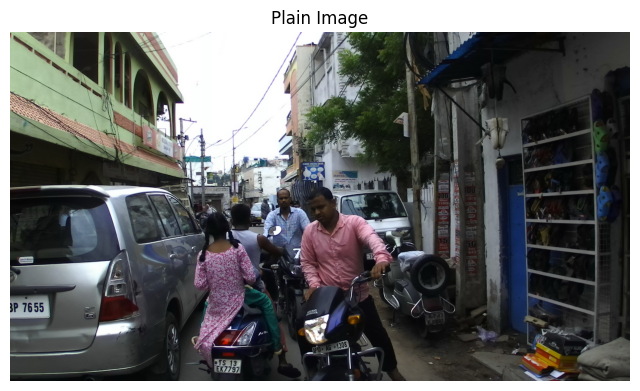

Evaluating model: Fine-Tuned-model-epochs-1


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([42, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([42]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


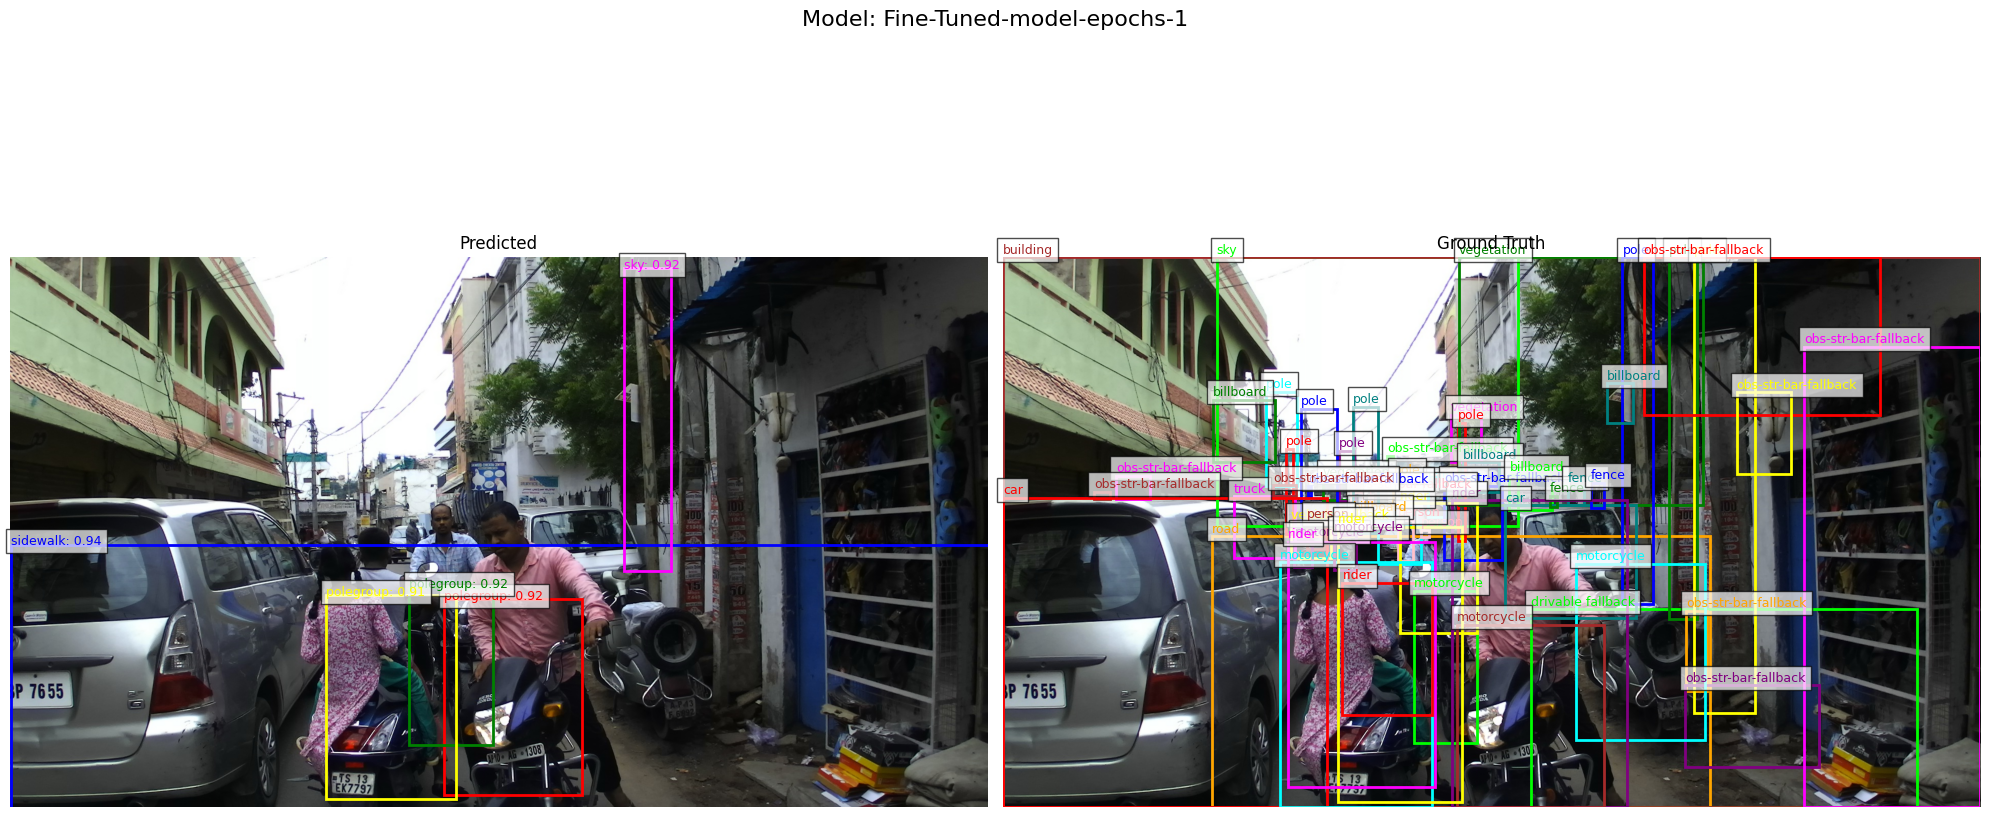

Evaluating model: Fine-Tuned-model-epochs-2


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([42, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([42]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


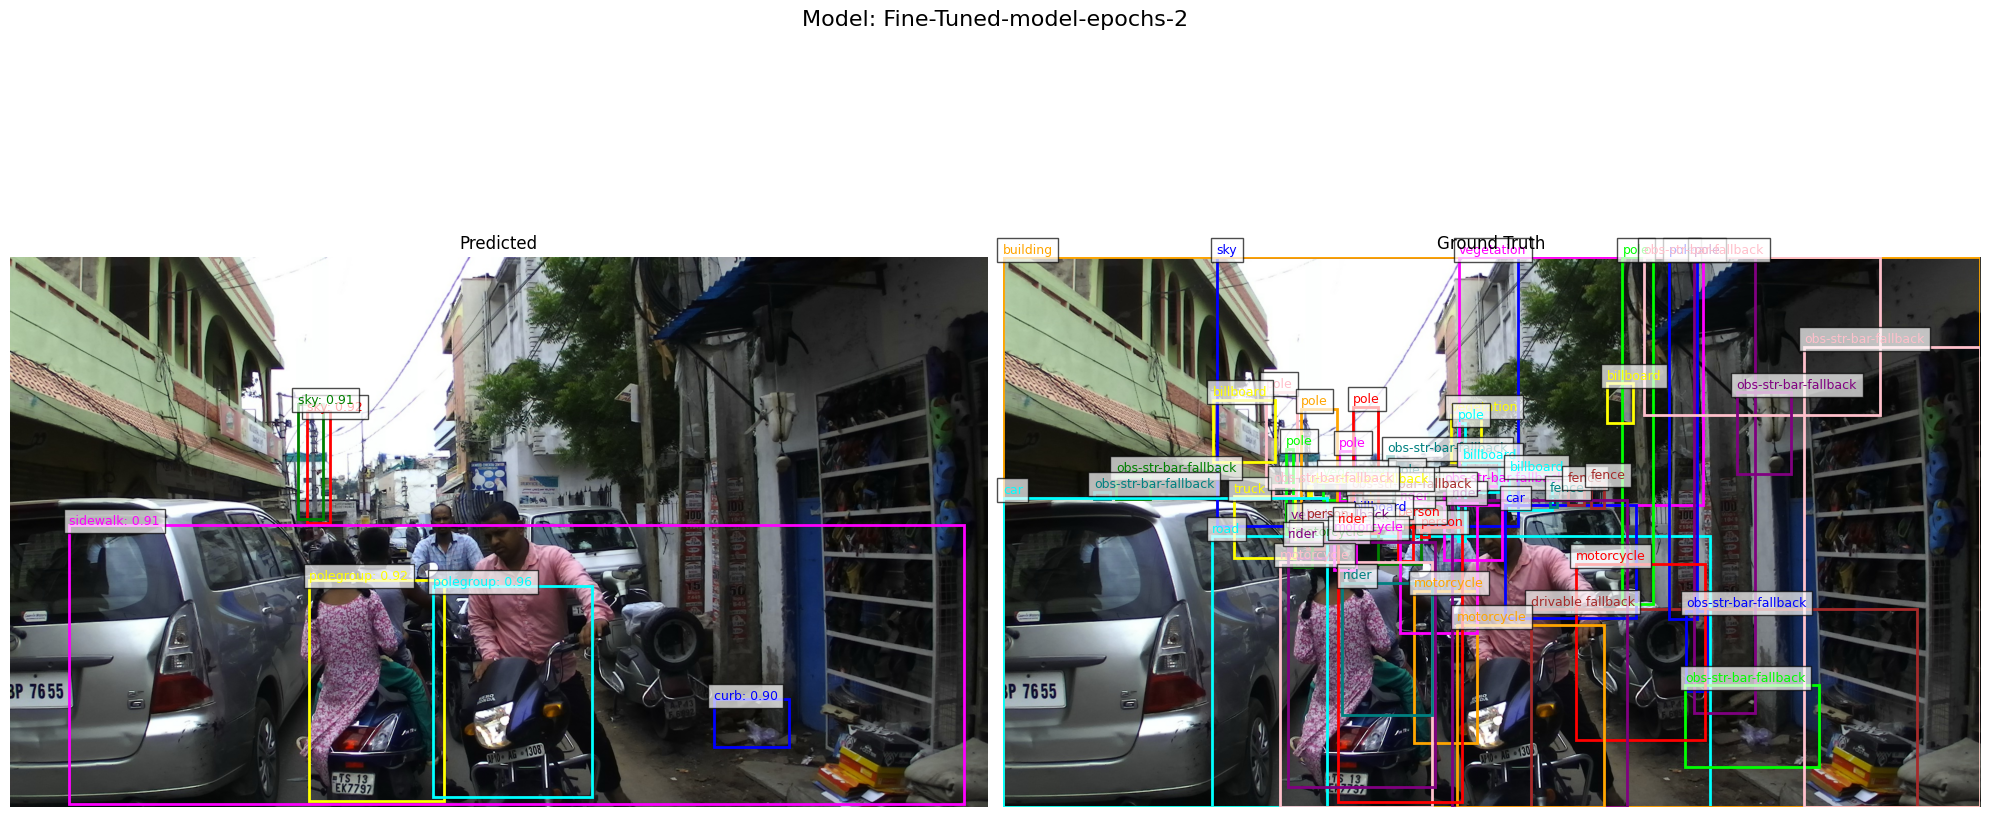

Evaluating model: Fine-Tuned-model-epochs-6


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([42, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([42]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


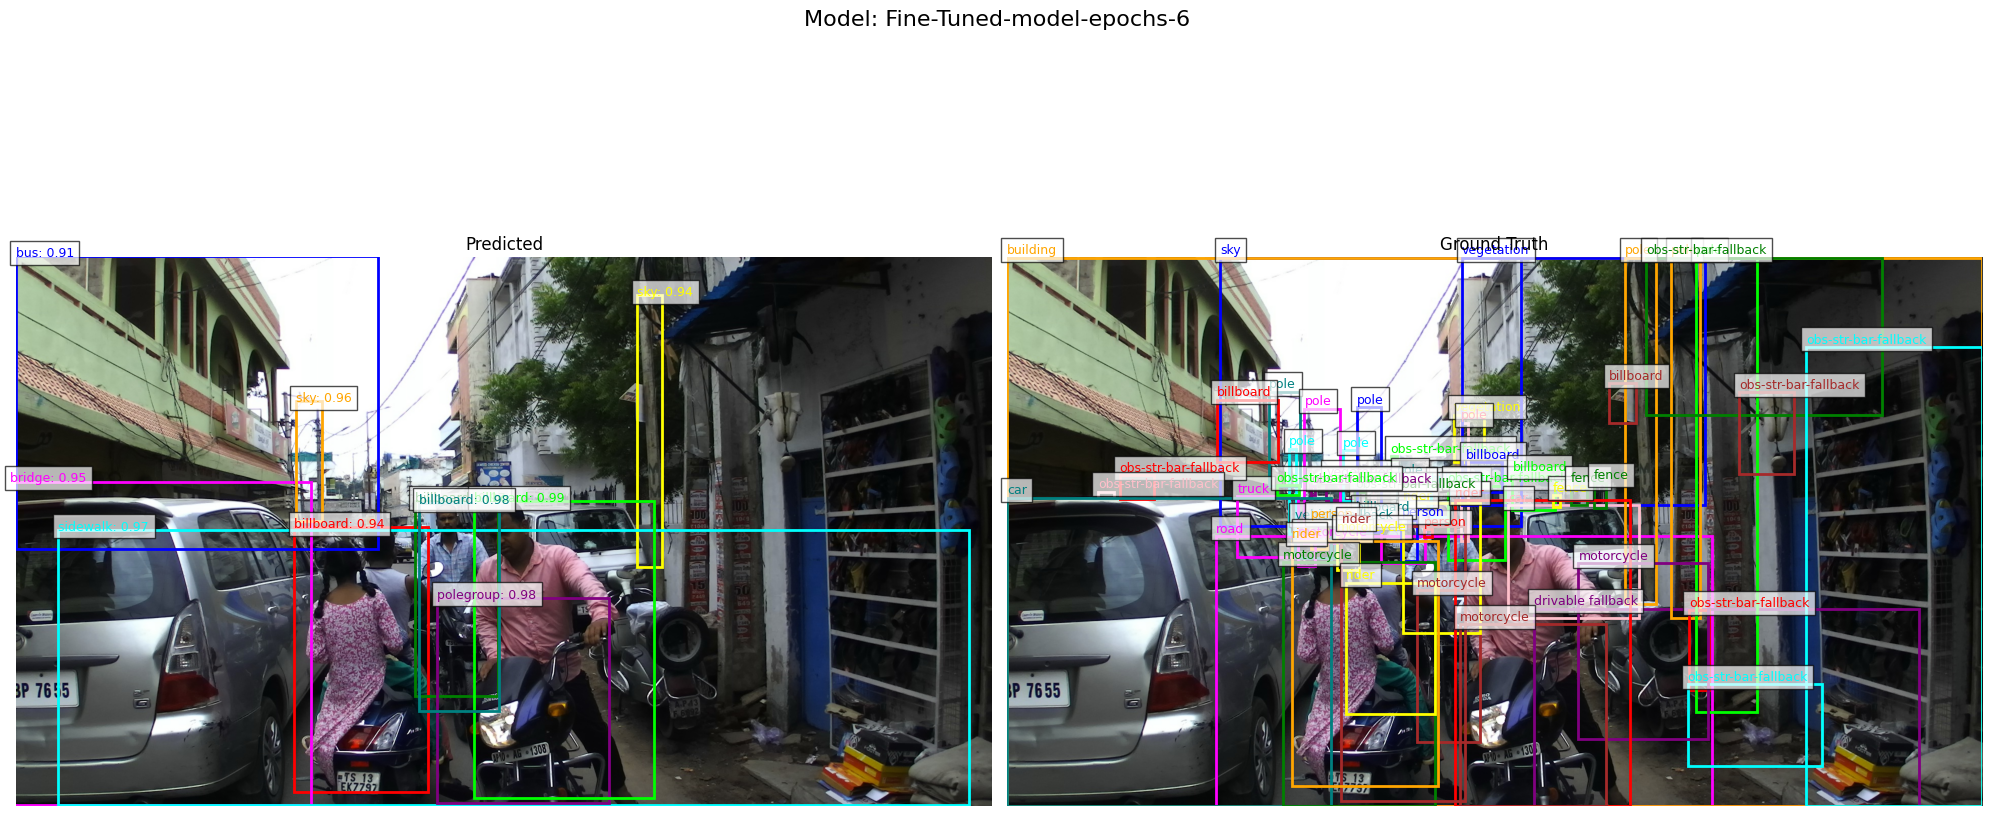

Evaluating model: Fine-Tuned-model-epochs-50


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([42, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([42]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


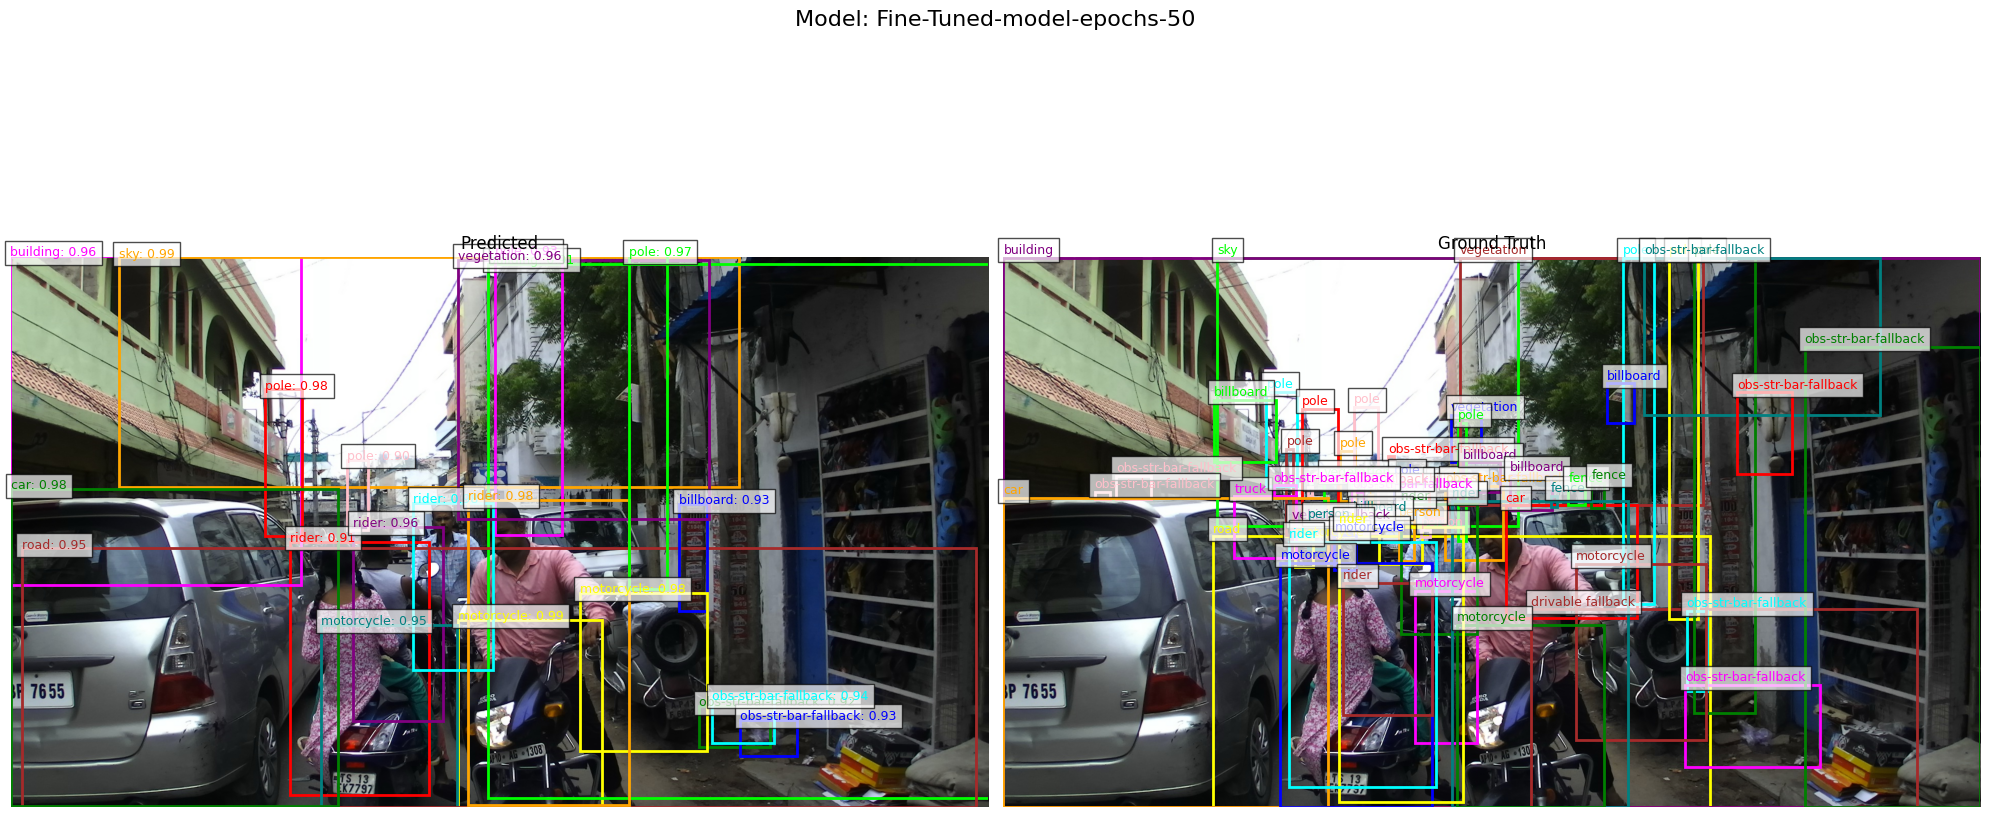

In [53]:
image = Image.open(image_path).convert("RGB")

# Display plain image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title("Plain Image")
plt.show()

for model_dir in model_dirs:
    print(f"Evaluating model: {model_dir}")
    
    # Load the ID to label mappings
    with open(os.path.join("Models",model_dir, "id2label.json"), 'r') as f:
        id2label = {int(k): v for k, v in json.load(f).items()}

    with open(os.path.join("Models",model_dir, "label2id.json"), 'r') as f:
        label2id = json.load(f)

    num_labels = len(id2label)

    # Initialize model with the correct number of labels and mappings
    model = DetrForObjectDetection.from_pretrained(
        "facebook/detr-resnet-50",
        revision="no_timm", 
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    # Load weights from safetensors file
    state_dict = load_file(os.path.join("Models",model_dir, "model.safetensors"))
    model.load_state_dict(state_dict)


    # Process the image
    inputs = processor(images=image, return_tensors="pt")

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)

    # Convert normalized coordinates to pixel coordinates
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                target_sizes=[(height, width)],
                                                                threshold=0.9)
    results = postprocessed_outputs[0]

    # Prepare data for the comparison function
    predicted_data = {
        'scores': results['scores'],
        'labels': results['labels'],
        'boxes': results['boxes']    }
    
    ground_truth_data = {
        'annotations': image_annotations,
        'cat_id_to_label': category
    }
    
    # Use the side-by-side comparison function
    plot_result(
        image, 
        predicted_data, 
        ground_truth_data,
        model,
        title=f"Model: {model_dir}"
    )

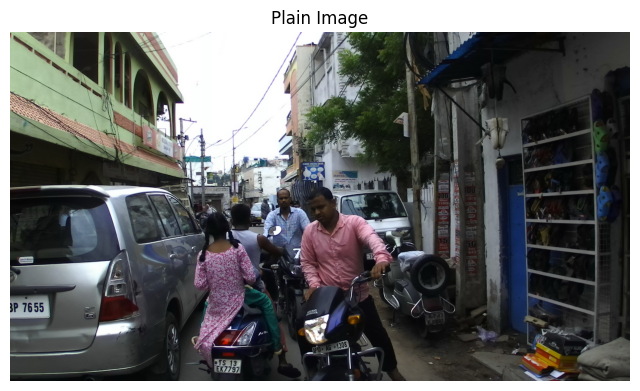

In [54]:
import matplotlib.pyplot as plt
image = Image.open(image_path).convert("RGB")

# Display plain image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis('off')
plt.title("Plain Image")
plt.show()

In [55]:
model_dir = 'Fine-Tuned-model-epochs-50'
print(f"Evaluating model: {model_dir}")

# Load the ID to label mappings
with open(os.path.join("Models",model_dir, "id2label.json"), 'r') as f:
    id2label = {int(k): v for k, v in json.load(f).items()}

with open(os.path.join("Models",model_dir, "label2id.json"), 'r') as f:
    label2id = json.load(f)

num_labels = len(id2label)
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
# Initialize model with the correct number of labels and mappings
model = DetrForObjectDetection.from_pretrained(
        "facebook/detr-resnet-50",
        revision="no_timm", 
        num_labels=num_labels,
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True
    )

    # Load weights from safetensors file
state_dict = load_file(os.path.join("Models",model_dir, "model.safetensors"))
model.load_state_dict(state_dict)

# Process the image
inputs = processor(images=image, return_tensors="pt")

# Run inference
with torch.no_grad():
    outputs = model(**inputs)


# Convert normalized coordinates to pixel coordinates
width, height = image.size
postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                            target_sizes=[(height, width)],
                                                            threshold=0.7)

Evaluating model: Fine-Tuned-model-epochs-50


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([42, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([42]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
results=postprocessed_outputs[0]
results

{'scores': tensor([0.8563, 0.9086, 0.7856, 0.7342, 0.9243, 0.9278, 0.9926, 0.9576, 0.8436,
         0.7145, 0.9366, 0.9871, 0.8869, 0.9574, 0.8912, 0.8096, 0.8196, 0.7676,
         0.8700, 0.8878, 0.9141, 0.9495, 0.7510, 0.8969, 0.9458, 0.9004, 0.9818,
         0.7321, 0.9796, 0.8830, 0.9345, 0.9784, 0.8635, 0.8621, 0.7115, 0.8108,
         0.7728, 0.9260, 0.7871, 0.9786, 0.9791, 0.8030, 0.7414, 0.7864, 0.9609,
         0.9663]),
 'labels': tensor([32, 25, 25,  5, 20, 20, 26, 29, 20, 32, 20,  7, 20, 25, 26, 20,  5, 26,
         32, 32, 29, 26, 26, 25, 38,  5,  5, 32, 37, 20, 32, 26, 25,  5, 20, 20,
         25,  5, 20, 25, 25, 20, 32,  5, 18,  5]),
 'boxes': tensor([[ 8.9272e+02,  3.9012e+02,  9.8053e+02,  4.7309e+02],
         [ 5.4747e+02,  5.5819e+02,  8.2135e+02,  1.0563e+03],
         [ 7.7900e+02,  4.9662e+02,  9.3159e+02,  7.5900e+02],
         [ 5.6207e+02,  3.0837e+02,  6.1052e+02,  4.9982e+02],
         [ 1.3520e+03,  8.8141e+02,  1.4915e+03,  9.6163e+02],
         [ 1.4324e+

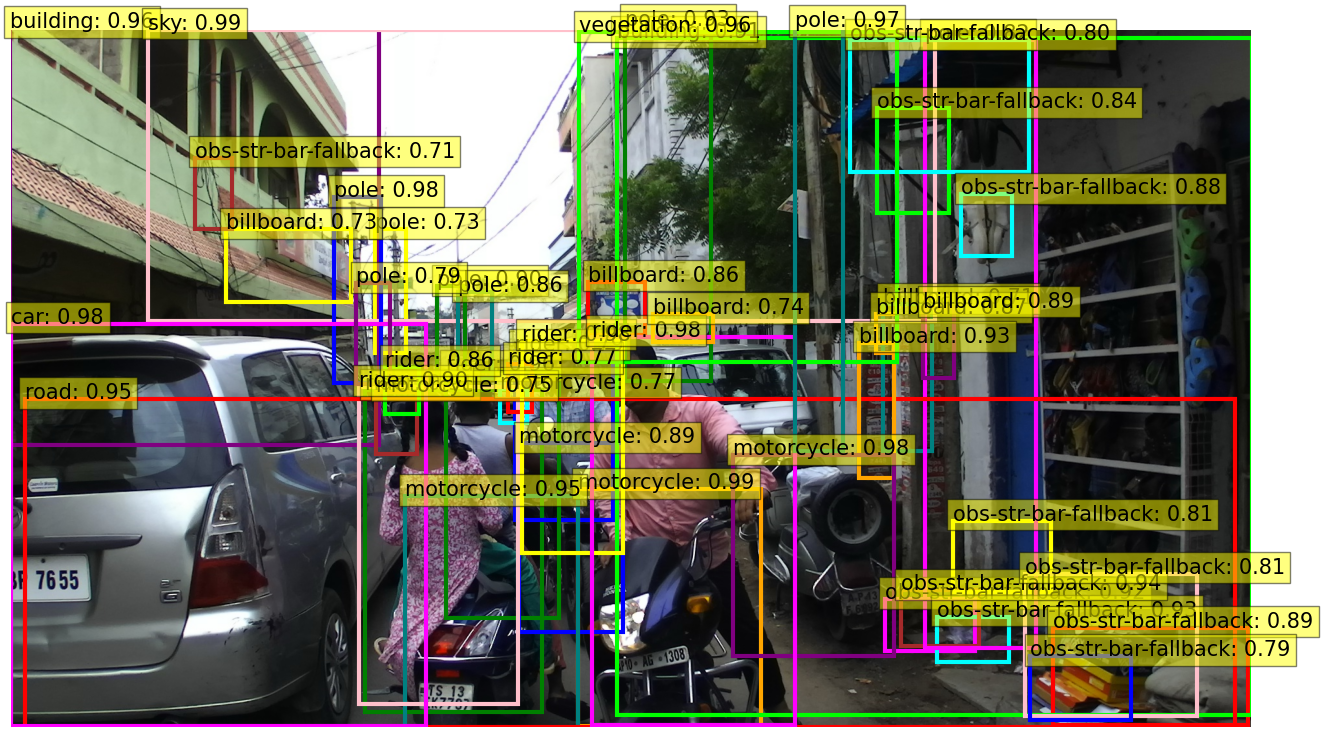

In [57]:
def plot_and_save(pil_img, scores, labels, boxes, save_path):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(
            scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle(
            (xmin, ymin), xmax - xmin, ymax - ymin,
            fill=False, color=c, linewidth=3
        ))
        text = f'{model.config.id2label[label]}: {score:.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    #plt.savefig(save_path, bbox_inches='tight')
    #plt.show()
    return 
# call and save
plot_and_save(image, results['scores'], results['labels'], results['boxes'], 'plot_result.png')